# Contribution profiles in real networks 

In [1]:
import random
import pickle
import gzip
from pathlib import Path
import numpy as np
import pandas as pd
import igraph as ig
import networkx as nx
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from msb import Balance

#%matplotlib inline
sns.set_theme(
    context="notebook",
    style="ticks",
    font_scale=1.3,
    palette="deep"
)

COLORS = np.array(["#7aa063", "#c86b57", "#9d6ebd"])
RED    = "#f97959"
BLUE   = "#60a1f7"
GRAY   = "#efefef"

# Paths
HERE = Path(".").absolute()
ROOT = HERE.parent.parent
DATA = ROOT/"data"
FIGS = ROOT/"figs"
FIGS.mkdir(exist_ok=True)

# Load MSB balance objects
with gzip.open(HERE/"data.pkl.gz", "rb") as fh:
    BALANCE = pickle.load(fh)

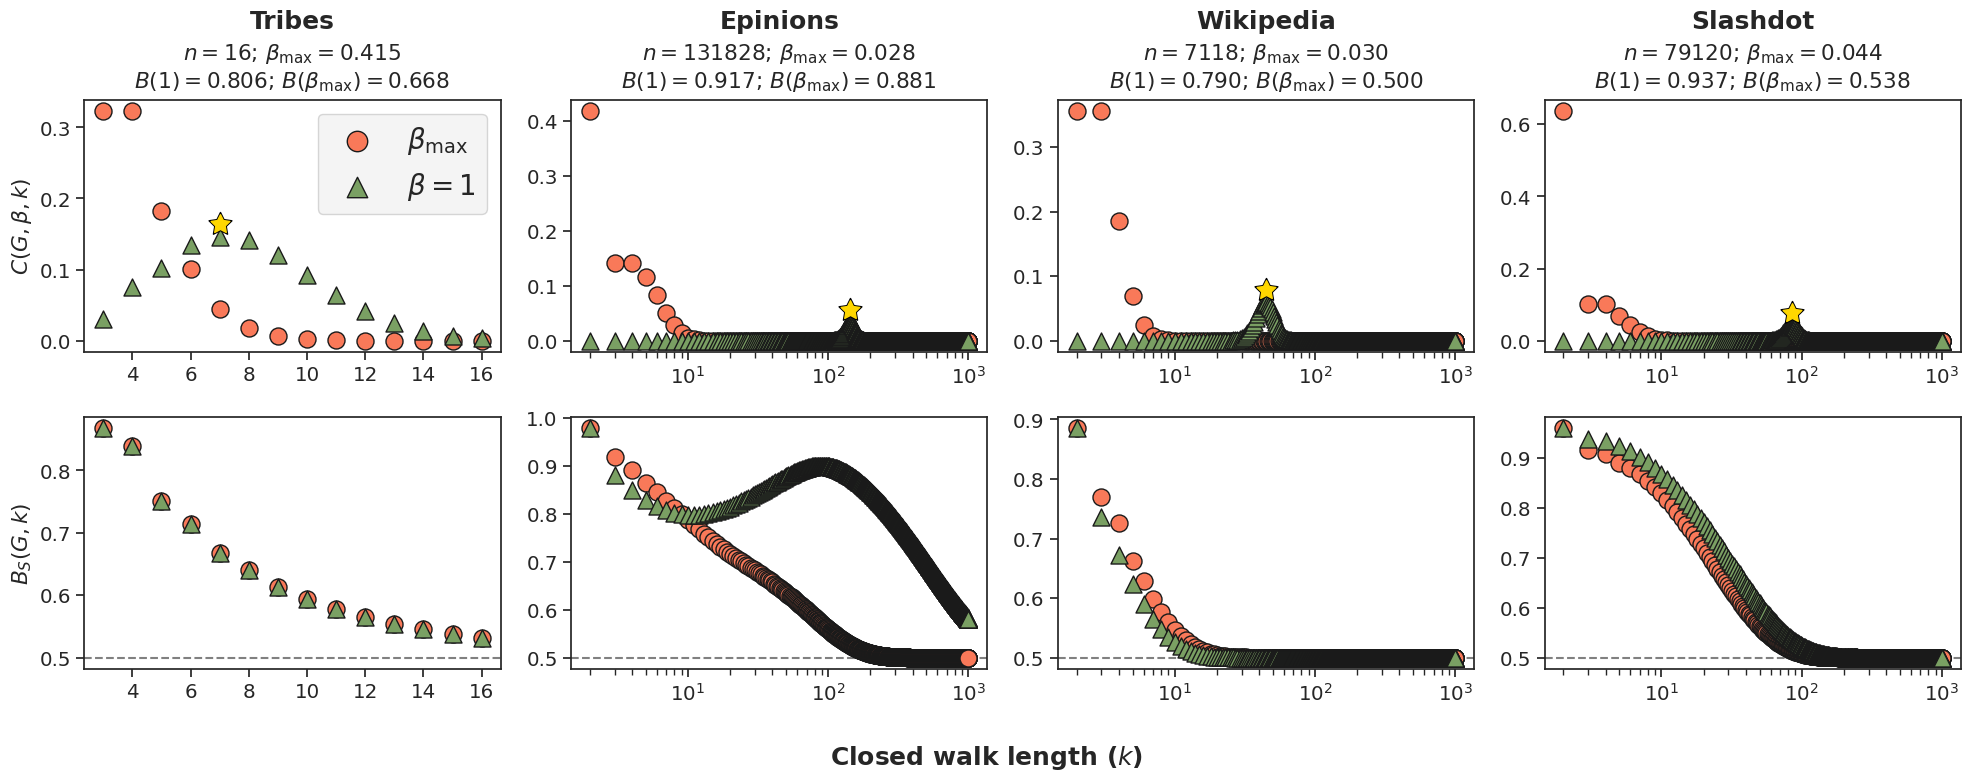

In [2]:
fig, axes = plt.subplots(ncols=len(BALANCE), nrows=2, figsize=(20, 8))

for kv, axrow in zip(BALANCE.items(), axes.T): 
    name, B = kv
    Bmax = B["Beta-max"]
    Cmax = B["Beta-max-C"].reset_index("beta", drop=True)
    beta_max = B["Beta-max-C"].index.get_level_values("beta")[0]
    n_nodes = B["Beta-params"]["n_nodes"]
    B1 = B["Beta-1"]
    C1 = B["Beta-1-C"].reset_index("beta", drop=True)
    ax = axrow[0]
    skws = dict(s=150, edgecolors="k")
    ax.scatter(Cmax.index, Cmax, color=RED, label=r"$\beta_{\max}$", marker="o", **skws)
    ax.scatter(C1.index, C1, color=COLORS[0], label=r"$\beta = 1$", marker="^", **skws)
    ax.set_title(name, fontweight="bold", fontsize=18, y=1.25)
    dobmax = (Bmax*Cmax).sum()
    dob1 = (B1*C1).sum()
    info = rf"$n = {n_nodes}$; $\beta_{{\max}} = {beta_max:.3f}$" 
    dobs = rf"$B(1) = {dobmax:.3f}$; $B(\beta_{{\max}}) = {dob1:.3f}$"
    ax.annotate(f"{info}\n{dobs}", (.5, 1.05), xycoords="axes fraction", ha="center")

    # Show peak for C1
    y0, y1 = ax.get_ylim()
    kpeak = C1.idxmax()
    peak  = C1.max()+(y1-y0)*.05
    ax.scatter(kpeak, peak, marker=(5,1), s=300, c="black")
    ax.scatter(kpeak, peak, marker=(5,1), s=200, c="gold")

    if name == "Tribes":
        ax.set_ylabel(r"$C(G, \beta, k)$")
        ax.legend(fontsize=20, markerscale=1.2, facecolor="#f2f2f2")

    ax = axrow[1]
    ax.scatter(Bmax.index, Bmax, color=RED, marker="o", **skws)
    ax.scatter(B1.index, B1, color=COLORS[0], marker="^", **skws)
    ax.axhline(.5, ls="--", color="gray", zorder=-10)

    if name == "Tribes":
        ax.set_ylabel(r"$B_S(G, k)$")

    for ax in axrow:
        if n_nodes >= 1000:
            ax.set_xscale("log")
        else:
            ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))

fig.supxlabel(r"Closed walk length ($k$)", fontweight="bold", fontsize=18)
fig.tight_layout()

fig.savefig(FIGS/"contrib.png", bbox_inches="tight")

# Comparison with local balance based on simple cycles

In [3]:
data = []
for name, objs in BALANCE.items():
    B = objs["Beta-max"]
    W = objs["Beta-1"]
    C = objs["simple"]
    k0 = B.index.min()
    k1 = B.index.max()
    k1 = min(k1, len(C))
    C = C[k0:k1]
    K = np.arange(k0, k1)
    df = pd.DataFrame({
        "B": B,
        "W": W,
        "C": 1-C
    }, index=pd.Series(K, name="K"))
    data.append(df)

data = pd.concat(data, keys=pd.Series(list(BALANCE), name="name"))

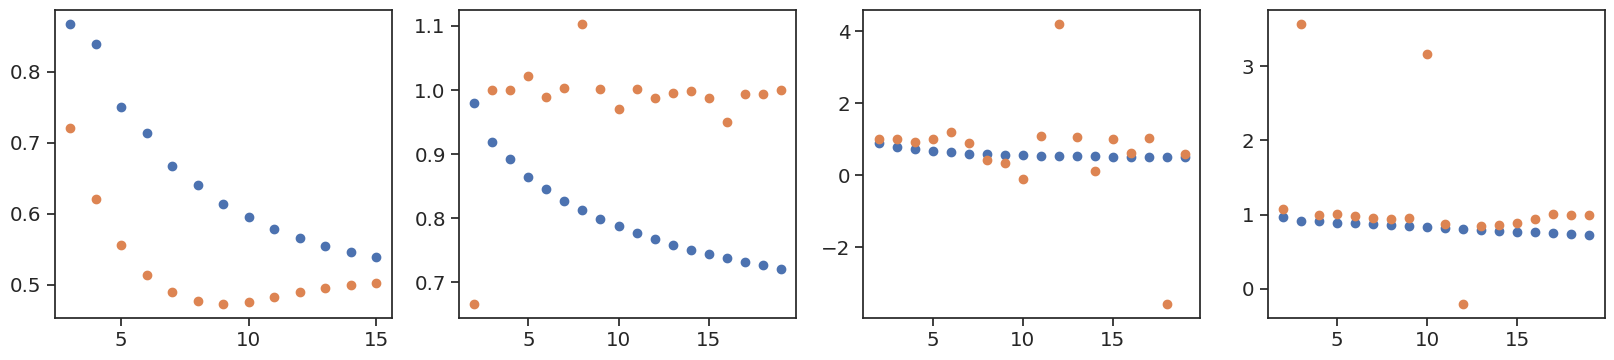

In [4]:
fig, axes = plt.subplots(ncols=len(BALANCE), figsize=(20, 4))

for name, ax in zip(BALANCE.keys(), axes.flat):
    df = data.loc[name]
    ax.scatter(df.index, df["B"])
    ax.scatter(df.index, df["C"])